# $n$-step TD on a random walk

We consider a modified random Markov process (MRP) presented in example 6.2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
from numba import prange
from tqdm import tqdm
from itertools import product

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"

In [118]:
np.set_printoptions(linewidth=150, suppress=True, precision=4)

The state-value update using TD-1 is
$$
V(S_t) \gets V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right].
$$

The state-value update using TD-2 is
$$
V(S_t) \gets V(S_t) + \alpha\left[ R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}) - V(S_t) \right].
$$

For any $n>2$, the state-value update of TD-$n$ is
$$
V(S_t) \gets V(S_t) + \alpha\left[\sum_{k=1}^n \gamma^{k-1} R_{t+k} + \gamma^n V(S_{t+n}) - V(S_t) \right].
$$

**Note**: for an episode with $T$ timesteps, if $n \geq T$, then TD reduces to an MC update.

In [119]:
n_states = 19 + 1 # total state plus terminal state
states = np.arange(n_states)
mrp = np.zeros((n_states, n_states))
mrp[0, 0] = 1.0

for i in range(1, n_states):
    iprev = i - 1
    inext = (i + 1) % n_states
    mrp[i, [i - 1, inext]] = 1/2

mrp

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0

In [7]:
n = n_states -1
reward_matrix = np.eye(n)
reward_matrix = reward_matrix - np.eye(n, k=1) / 2 - np.eye(n, k=-1) / 2
y = np.zeros(n)
y[-1] = 1/2
y[0] = -1/2

value_array = np.linalg.solve(reward_matrix, y)

In [8]:
@njit
def set_seed(seed):
    np.random.seed(seed)


@njit
def sample_run(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r = 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist[:-1])
    r_hist = np.array(r_hist)
    return s_hist, r_hist

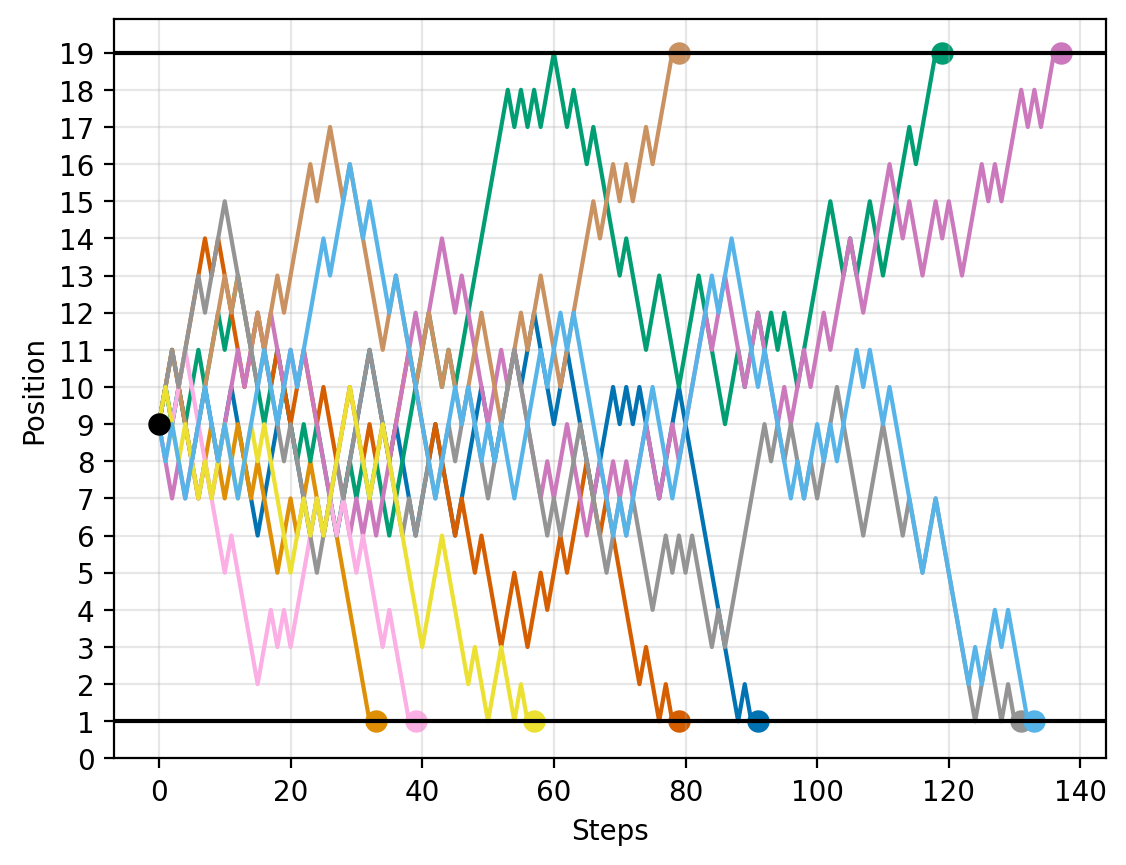

In [55]:
n_sims = 10
s_init = 9

set_seed(3141)
for n in range(n_sims):
    s_hist, r_hist = sample_run(s_init)
    len_hist = len(s_hist)
    plt.plot(s_hist)
    plt.scatter(len_hist, s_hist[-1], s=50)

plt.scatter(0, s_init, c="black", zorder=2, s=50)
plt.axhline(y=n_states - 1, c="black")
plt.axhline(y=1, c="black")
plt.ylabel("Position")
plt.xlabel("Steps")
plt.yticks(np.arange(0, n_states))
plt.grid(alpha=0.3)

In [78]:
@njit
def compute_reward(sprev, snext):
    if (sprev == n_states - 1) and (snext == 0):
        r = 1
    elif (sprev == 1) and (snext == 0):
        r = -1
    else:
        r = 0

    return r


@njit
def run_and_update_tdn(value, s, alpha, gamma, td_size):
    """
    Sample from the MRP and update the TD-n algorithm
    ----
    Parameters:
    value: np.array
        Current value estimate
    s: float
        initial state
    alpha: float
        learning rate
    gamma: float
        discount
    rewards_td: np.array
        FIFO buffer of rewards
    """
    value = value.copy()
    
    rewards_td = np.zeros(td_size) * np.nan # rewards in the buffer
    states_td = -np.ones(td_size, dtype=np.int32) # states S_{t+n} to update
    discount_array = gamma ** np.arange(td_size)

    # Run simulation and fill buffer
    while s != 0:
        # 1. take action
        snext = np.random.multinomial(1, mrp[s]).argmax()
        
        # 2. observe reward and store
        r = compute_reward(s, snext)
        
        rewards_td = np.roll(rewards_td, -1)
        rewards_td[-1] = r
        
        states_td = np.roll(states_td, -1)
        states_td[-1] = snext
        
        
        # If the buffer is not filled, we haven't reached the pair S_t -> S_{t+n}.
        if np.any(np.isnan(rewards_td)):
            s = snext
            continue

        s_back = states_td[0]
        target = (discount_array * rewards_td).sum() + gamma ** td_size * value[s_back]
        value[s] = value[s] + alpha * (target - value[s])
        
        s = snext

    # Exhaust elements in the buffer: MC style.
    for i, s in enumerate(states_td, 1):
        # terminal or non-valid state
        if (s == -1) or (s == 0):
            continue

        subset = rewards_td[i:]
        lsubset = len(subset)
        discounts = gamma ** np.arange(lsubset)
        G = (discounts * subset).sum()
        value[s] = value[s] + alpha * (G - value[s])

    return value


@njit(parallel=True)
def tdn_value_sims(
        value_init, sinit, alpha, gamma, td_size, n_sims, n_episodes
    ):
    value_all = np.zeros((n_sims, len(value_init)))
    for n in prange(n_sims):
        value = value_init.copy()
        for e in range(n_episodes):
            value = run_and_update_tdn(value, sinit, alpha, gamma, td_size)
        value_all[n] = value
    return value_all

In [79]:
value_init = np.zeros(n_states)

gamma  = 1.0
sinit = 9

n_episodes = 200
n_sims = 100

In [80]:
n_values =[2 ** n for n in range(10)]
alpha_values = np.linspace(0, 1, 50)

In [160]:
items = list(product(n_values, alpha_values))

collection = []
for td_size, a in tqdm(items):
    value = tdn_value_sims(value_init, sinit, a, gamma, td_size, n_sims, n_episodes)
    value[value == -1] = np.nan
    
    err = np.power(value[:, 1:] - value_array, 2)
    err = np.nanmean(np.sqrt(np.nanmean(err, axis=-1)))
    collection.append({
        "n": td_size,
        "alpha": a,
        "rmse": err,
    })

 39%|██████████████████████████████████████████████████                                                                             | 197/500 [00:06<00:13, 23.04it/s]/tmp/ipykernel_1567456/1728706931.py:9: RuntimeWarning: Mean of empty slice
  err = np.nanmean(np.sqrt(np.nanmean(err, axis=-1)))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.38it/s]


In [161]:
value_array

array([-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [162]:
res = pd.DataFrame(collection)

In [163]:
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))

Text(0.5, 0, '$\\alpha$')

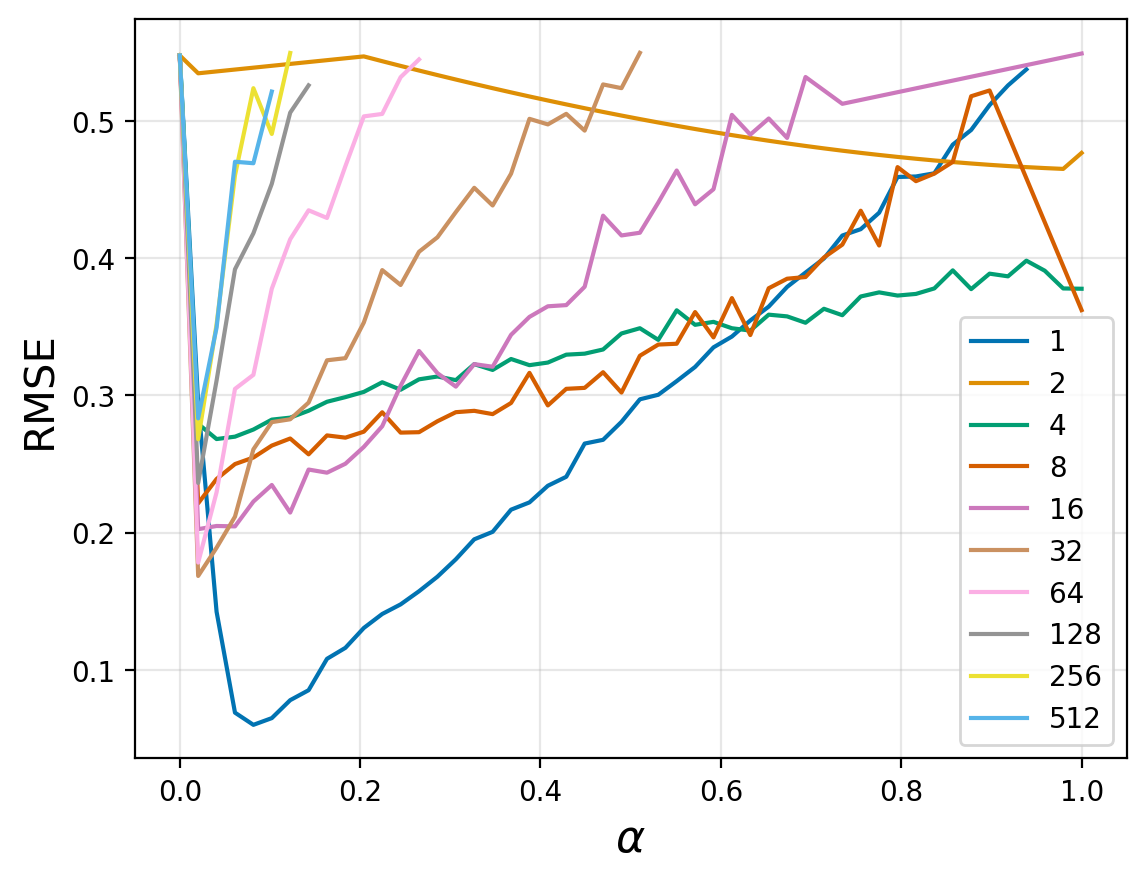

In [181]:
for c, n in zip(colors, n_values):
    res.query("n == @n").query("rmse < 0.55").set_index("alpha")["rmse"].plot(label=n)
plt.grid(alpha=0.3)
plt.ylabel("RMSE", fontsize=15)
plt.legend()
plt.xlabel(r"$\alpha$", fontsize=16)

In [193]:
td_size = 2
a = 0.4
value = tdn_value_sims(value_init, sinit, a, gamma, td_size, n_sims, n_episodes)

In [194]:
value

array([[ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6],
       [ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6],
       [ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6],
       ...,
       [ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6],
       [ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6],
       [ 0. , -1.6,  0. , ...,  0. ,  0. ,  1.6]])

In [187]:
np.sqrt((np.power(value[:, 1:] - value_array, 2).mean(axis=1))).mean()

0.5160579322844326

In [188]:
np.sqrt((np.power(value_array, 2).mean(axis=0))).mean()

0.5477225575051661